Uncomment lines in the below cell to install data and software dependencies.

In [1]:
# !pip install --quiet quandl plotly git+https://github.com/ethho/memoize.git lmfit
# !mkdir -p ./data/final_proj
# !wget --quiet -O final_proj.py https://github.com/ethho/finm-33150/raw/main/final_proj.py
# !wget --quiet -O strat_returns.py https://github.com/ethho/finm-33150/raw/main/strat_returns.py
# !wget --quiet -O data/final_proj/uszcb.csv https://github.com/ethho/finm-33150/raw/main/data/final_proj/uszcb.csv

In [2]:
import os
import sys
import json
from glob import glob
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS, RollingWLS
import final_proj
import strat_returns

%matplotlib inline
# pd.options.display.float_format = '{:,.4f}'.format

DARK_MODE = False
if DARK_MODE:
    plt.style.use('dark_background')
    plotly_template = 'plotly_dark'
else:
    plt.style.use('ggplot')
    plotly_template = 'ggplot2'

# 20230307_p_model

Ethan Ho 3/7/2023

@mpcs
@finm

----

The purpose of this notebook is to start building a predictive regression model as described in project [Part B](https://docs.google.com/document/d/1u4z5A9VYVPIAdJ36OfEpMQiQ67zj7iVXDmkjXtAMoIQ/edit#heading=h.f1f687128v9c).

# Fetch Data

In [124]:
!python3 strat_returns.py

Using first non-null date as start_date='2001-08-29'
Using first non-null date as start_date='2001-08-29'
Wrote 'hedge_factors' to ./data/final_proj/strat_n1A_135_hedge_factors.csv
Wrote 'signal' to ./data/final_proj/strat_n1A_135_signal.csv
Wrote 'pnl' to ./data/final_proj/strat_n1A_135_pnl.csv
Wrote 'params' to ./data/final_proj/strat_n1A_135_params.json
Using first non-null date as start_date='2001-08-29'
Using first non-null date as start_date='2001-08-29'
Wrote 'hedge_factors' to ./data/final_proj/strat_n2A_0510_hedge_factors.csv
Wrote 'signal' to ./data/final_proj/strat_n2A_0510_signal.csv
Wrote 'pnl' to ./data/final_proj/strat_n2A_0510_pnl.csv
Wrote 'params' to ./data/final_proj/strat_n2A_0510_params.json
Using first non-null date as start_date='2001-08-29'
Using first non-null date as start_date='2001-08-29'
Wrote 'hedge_factors' to ./data/final_proj/strat_n2A_220_hedge_factors.csv
Wrote 'signal' to ./data/final_proj/strat_n2A_220_signal.csv
Wrote 'pnl' to ./data/final_proj/str

# Plot Results of Naive Strategy 2-A (0.5 and 10 year maturities)

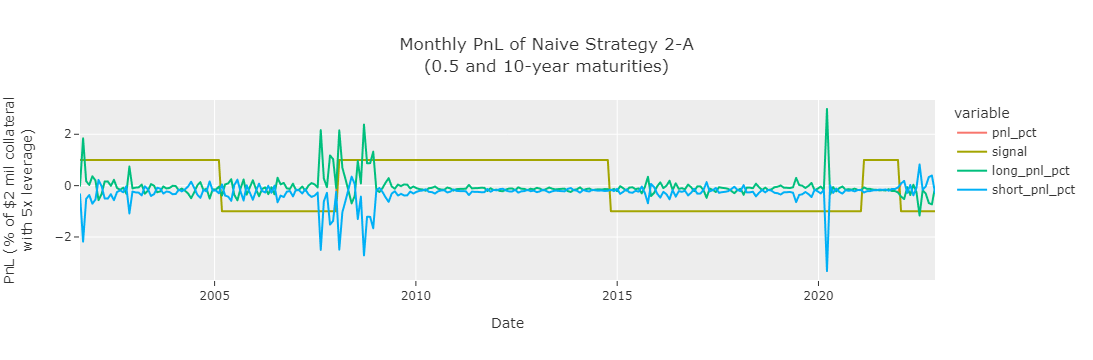

In [125]:
def plot_pnl(strat_name, **kw):
    fp = f"./data/final_proj/{strat_name}_pnl.csv"
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    fig = px.line(
        df[[
            'pnl_pct', 'signal',
            'long_pnl_pct', 'short_pnl_pct'
        ]].rename({
        }),
        labels = {
            'date': 'Date',
            'value': 'PnL (% of $2 mil collateral<br>with 5x leverage)',
        },
        
        template=plotly_template,
        **kw
    )
    return fig

plot_pnl(
    'strat_n2A_0510',
    title=f'Monthly PnL of Naive Strategy 2-A<br>(0.5 and 10-year maturities)'
)

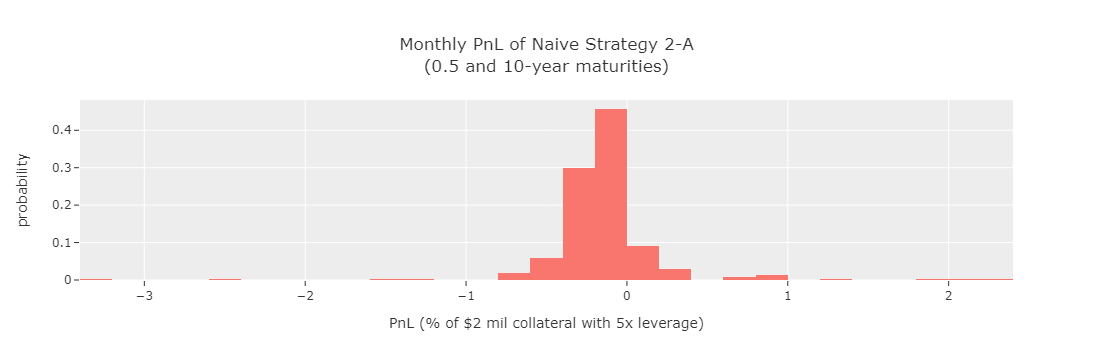

In [126]:
def plot_pnl_dist(strat_name, **kw):
    fp = f"./data/final_proj/{strat_name}_pnl.csv"
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    fig = px.histogram(
        df.loc[df['signal'] != 0., 'pnl_pct'],
        labels = {
            'date': 'Date',
            'value': 'PnL (% of $2 mil collateral with 5x leverage)',
        },
        # cumulative=True,
        histnorm='probability',
        template=plotly_template,
        **kw
    )
    fig.update_layout(showlegend=False)
    return fig

plot_pnl_dist(
    'strat_n2A_0510',
    title=f'Monthly PnL of Naive Strategy 2-A<br>(0.5 and 10-year maturities)',
    nbins=30,
)

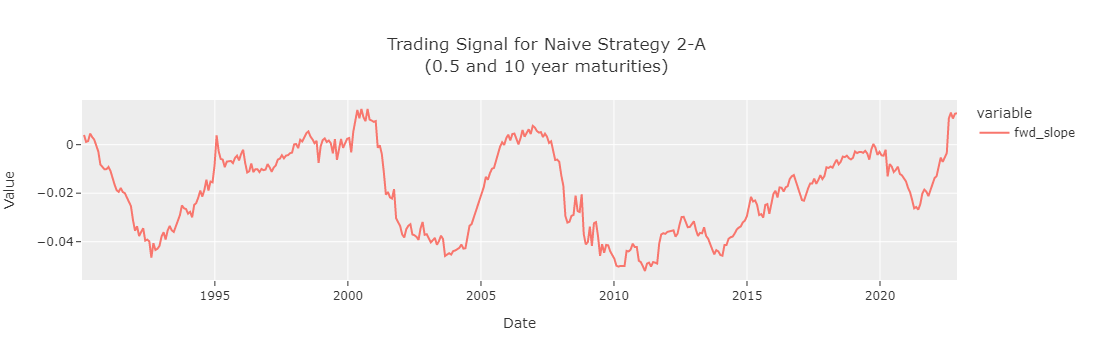

In [127]:
def plot_signal(strat_name, cols, **kw):
    fp = f"./data/final_proj/{strat_name}_signal.csv"
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    fig = px.line(
        df[cols].rename({
        }),
        labels = {
            'date': 'Date',
            'value': 'Value',
        },
        template=plotly_template,
        **kw
    )
    return fig

plot_signal(
    'strat_n2A_0510',
    cols=['fwd_slope'],
    title=f'Trading Signal for Naive Strategy 2-A<br>(0.5 and 10 year maturities)',
)

# Plot Results of Naive Strategy 3-A (0.25, 1, 5 year maturities) Grid Search

In [128]:
!ls data/final_proj/strat_n3A*.csv

data/final_proj/strat_n3A_02515_hedge_factors.csv
data/final_proj/strat_n3A_02515_pnl.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size102_hedge_factors.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size102_pnl.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size102_signal.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size13_hedge_factors.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size13_pnl.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size13_signal.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size26_hedge_factors.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size26_pnl.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size26_signal.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size52_hedge_factors.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size52_pnl.csv
data/final_proj/strat_n3A_02515_sigma_thresh0.25_window_size52_signal.csv
dat

In [129]:
def parse_pnl_grid_search(strat_name, rf=0., **kw):
    pattern = f"./data/final_proj/{strat_name}_*_pnl.csv"
    results = dict()
    for fp in glob(pattern):
        stub = '_'.join(fp.split('_')[:-1])
        with open(f"{stub}_params.json", "r") as f:
            paramset = json.load(f)
        paramset['file_stub'] = os.path.basename(paramset['file_stub'])
        df = pd.read_csv(fp, index_col=0, parse_dates=True)
        results[stub] = {
            'df': df,
            **paramset,
            # Sharpe when we are not flat
            'sharpe': (df.loc[df['signal'] != 0, 'pnl'].mean() - rf) / df.loc[df['signal'] != 0, 'pnl'].std(),
            'fig': px.scatter(
                df[[
                    'pnl_pct', 'signal',
                    'long_pnl_pct', 'short_pnl_pct'
                ]].rename({
                }),
                labels = {
                    'date': 'Date',
                    'value': 'PnL (% of $2 mil collateral<br>with 5x leverage)',
                },

                template=plotly_template,
                **kw
            ),
        }
    
    # Generate summary DataFrame
    sum_df = pd.DataFrame.from_records([{
        k: v for k, v in result.items()
        if k not in ('df', 'fig',)
    } for result in results.values()])
    sum_df.sort_values(by='sharpe', ascending=False, inplace=True)
    return {
        'sum_df': sum_df,
        'results_dict': results,
        # 'fig': fig
    }

gs_results = parse_pnl_grid_search(
    'strat_n3A_135',
)
gs_results['sum_df']

,broker_borrow_rate,capital,file_stub,leverage,sigma_thresh,start_date,tenors,window_size,sharpe
10,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size102,5.0,0.25,None,"[52.0, 156.0, 260.0]",102,-0.082780
4,50,10000000,strat_n3A_135_sigma_thresh-0.5_window_size102,5.0,-0.50,None,"[52.0, 156.0, 260.0]",102,-0.089950
14,50,10000000,strat_n3A_135_sigma_thresh0_window_size102,5.0,0.00,None,"[52.0, 156.0, 260.0]",102,-0.091313
19,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size52,5.0,0.25,None,"[52.0, 156.0, 260.0]",52,-0.103904
2,50,10000000,strat_n3A_135_sigma_thresh1.0_window_size102,5.0,1.00,None,"[52.0, 156.0, 260.0]",102,-0.116298
13,50,10000000,strat_n3A_135_sigma_thresh0_window_size52,5.0,0.00,None,"[52.0, 156.0, 260.0]",52,-0.123442
0,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size26,5.0,0.25,None,"[52.0, 156.0, 260.0]",26,-0.126317
5,50,10000000,strat_n3A_135_sigma_thresh0_window_size26,5.0,0.00,None,"[52.0, 156.0, 260.0]",26,-0.126960
3,50,10000000,strat_n3A_135_sigma_thresh0.5_window_size102,5.0,0.50,None,"[52.0, 156.0, 260.0]",102,-0.127097
16,50,10000000,strat_n3A_135_sigma_thresh-0.5_window_size52,5.0,-0.50,None,"[52.0, 156.0, 260.0]",52,-0.130766


Let's plot the PnL of the best (least bad) parameter set in the grid search:

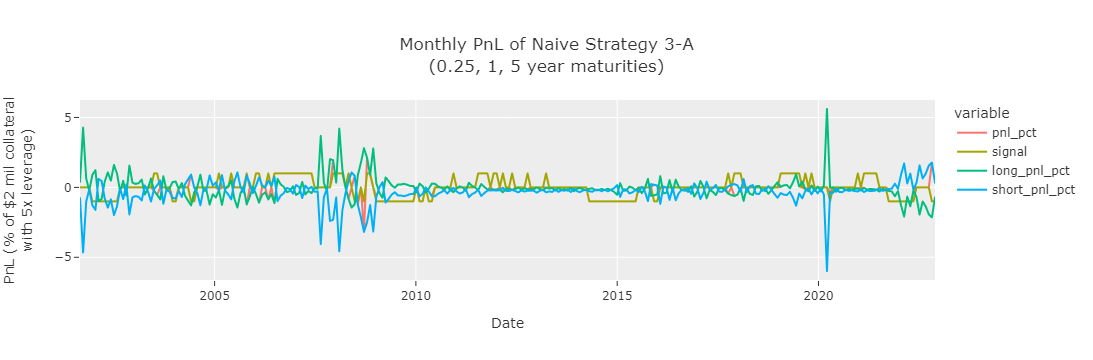

In [130]:
plot_pnl(
    'strat_n3A_135_sigma_thresh1.0_window_size52',
    title=f'Monthly PnL of Naive Strategy 3-A<br>(0.25, 1, 5 year maturities)'
)

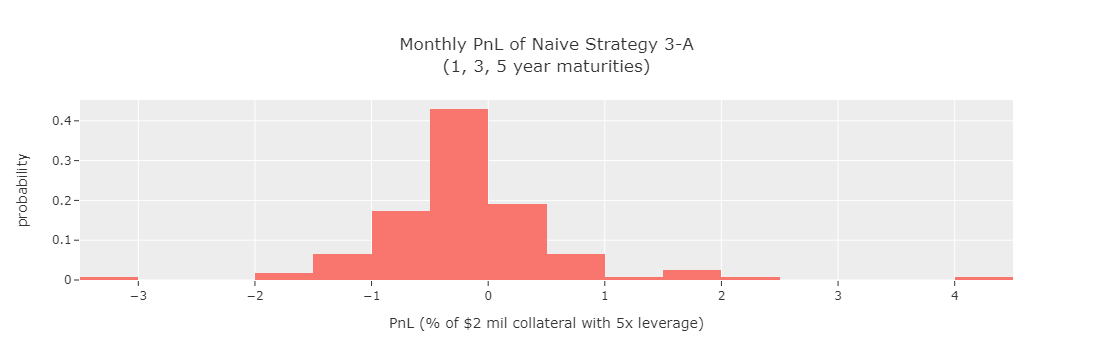

In [131]:
plot_pnl_dist(
    'strat_n3A_135_sigma_thresh1.0_window_size52',
    title=f'Monthly PnL of Naive Strategy 3-A<br>(1, 3, 5 year maturities)',
    nbins=30,
)

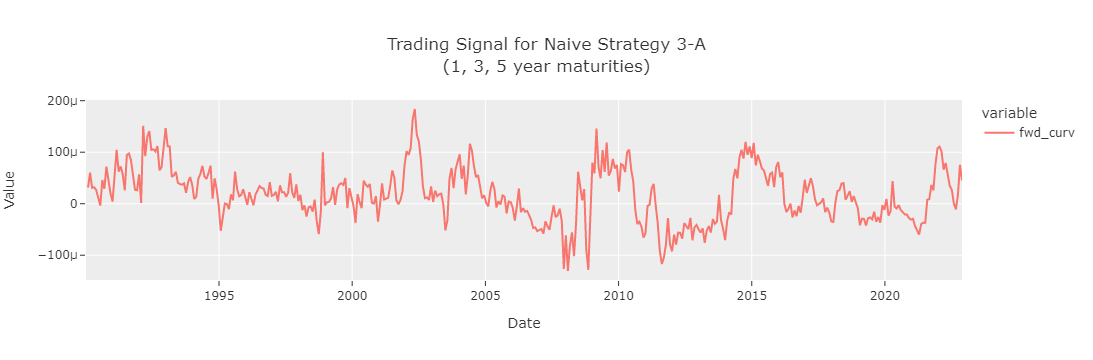

In [132]:
plot_signal(
    'strat_n3A_135_sigma_thresh1.0_window_size52',
    cols=['fwd_curv'],
    title=f'Trading Signal for Naive Strategy 3-A<br>(1, 3, 5 year maturities)',
)

# Plot Results of Naive Strategy 3-A (1, 3, 5 year maturities) Grid Search

In [133]:
gs_results = parse_pnl_grid_search(
    'strat_n3A_135',
)
gs_results['sum_df']

,broker_borrow_rate,capital,file_stub,leverage,sigma_thresh,start_date,tenors,window_size,sharpe
10,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size102,5.0,0.25,None,"[52.0, 156.0, 260.0]",102,-0.082780
4,50,10000000,strat_n3A_135_sigma_thresh-0.5_window_size102,5.0,-0.50,None,"[52.0, 156.0, 260.0]",102,-0.089950
14,50,10000000,strat_n3A_135_sigma_thresh0_window_size102,5.0,0.00,None,"[52.0, 156.0, 260.0]",102,-0.091313
19,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size52,5.0,0.25,None,"[52.0, 156.0, 260.0]",52,-0.103904
2,50,10000000,strat_n3A_135_sigma_thresh1.0_window_size102,5.0,1.00,None,"[52.0, 156.0, 260.0]",102,-0.116298
13,50,10000000,strat_n3A_135_sigma_thresh0_window_size52,5.0,0.00,None,"[52.0, 156.0, 260.0]",52,-0.123442
0,50,10000000,strat_n3A_135_sigma_thresh0.25_window_size26,5.0,0.25,None,"[52.0, 156.0, 260.0]",26,-0.126317
5,50,10000000,strat_n3A_135_sigma_thresh0_window_size26,5.0,0.00,None,"[52.0, 156.0, 260.0]",26,-0.126960
3,50,10000000,strat_n3A_135_sigma_thresh0.5_window_size102,5.0,0.50,None,"[52.0, 156.0, 260.0]",102,-0.127097
16,50,10000000,strat_n3A_135_sigma_thresh-0.5_window_size52,5.0,-0.50,None,"[52.0, 156.0, 260.0]",52,-0.130766


Let's look at one of the best performing (least bad) paramsets:

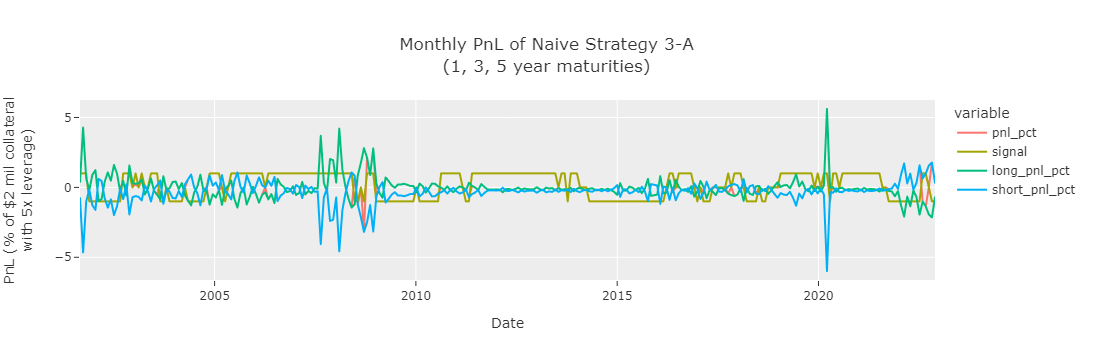

In [134]:
plot_pnl(
    'strat_n3A_135_sigma_thresh0.25_window_size102',
    title=f'Monthly PnL of Naive Strategy 3-A<br>(1, 3, 5 year maturities)',
)

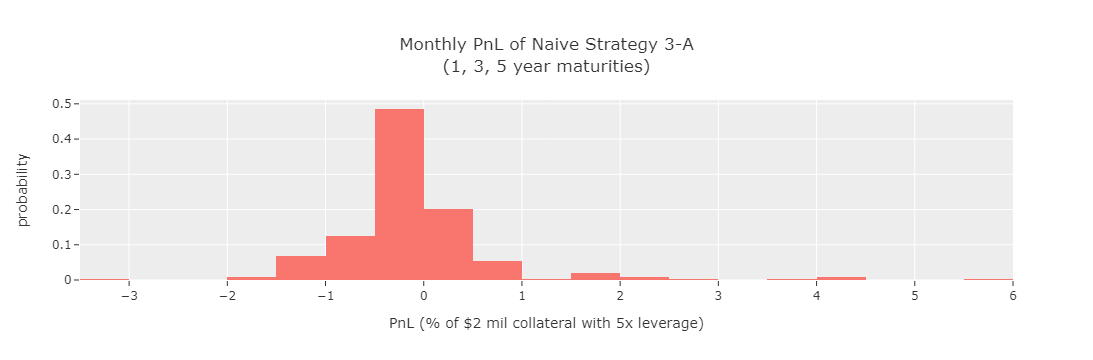

In [135]:
plot_pnl_dist(
    'strat_n3A_135_sigma_thresh0.25_window_size102',
    title=f'Monthly PnL of Naive Strategy 3-A<br>(1, 3, 5 year maturities)',
    nbins=30,
)

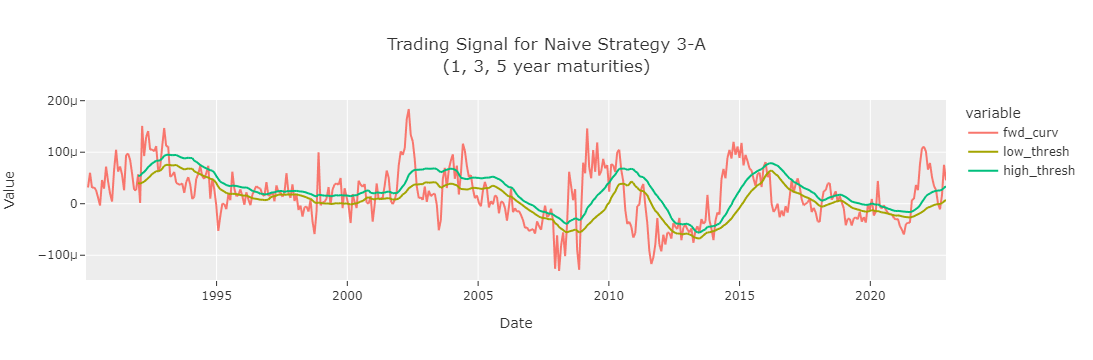

In [136]:
plot_signal(
    'strat_n3A_135_sigma_thresh0.25_window_size26',
    cols=['fwd_curv', 'low_thresh', 'high_thresh'],
    title=f'Trading Signal for Naive Strategy 3-A<br>(1, 3, 5 year maturities)',
)

This parameter set on the 1, 3, 5 year curve is promising. The curvature appears to mean revert, and the Sharpe is not horrendous at near zero.

# Fitting a Predictive Model

Now, we'll use this parameter set to try regressing today's PnL based on yesterday's curvature.

In [137]:
def fit_ols(strat_name, window_size=13, **kw):
    sig_fp = f"./data/final_proj/{strat_name}_signal.csv"
    pnl_fp = f"./data/final_proj/{strat_name}_pnl.csv"
    params_fp = f"./data/final_proj/{strat_name}_params.json"
    sig = pd.read_csv(sig_fp, index_col=0, parse_dates=True)
    pnl = pd.read_csv(pnl_fp, index_col=0, parse_dates=True)
    df = sig.merge(pnl, how='inner', left_index=True, right_index=True, suffixes=(None, '_pnl'))
    with open(params_fp, 'r') as f:
        params = json.load(f)
    
    # Recalculate the rolling mean from the forward curve
    df[['mean', 'std']] = df['fwd_curv'].rolling(window=window_size).agg(['mean', 'std'])
    df['curv_spread'] = (df['fwd_curv'] - df['mean']) / df['std']
    
    # Back out the transaction fees
    fees = df['1'] - df['pnl_no_fees']
    assert fees.std() < 1e-8
    fees_tot = fees.abs().iloc[0]
    collateral = params['capital'] / params['leverage']
    fees_pct = 100 * fees_tot / collateral
    print(f"Fees per trade: ${fees_tot:0.2f} ({fees_pct:0.3f}% of collateral=${collateral:0.0f})")
    
    fig = px.scatter(
        df.rename({
        }),
        x='curv_spread',
        y='pnl_no_fees_pct',
        trendline='ols',
        trendline_options={
            'add_constant': False,
        },
        labels = {
            'date': 'Date',
            'value': 'PnL (% of $2 mil collateral<br>with 5x leverage)',
        },
        template=plotly_template,
        **kw
    )
    return {
        'fig': fig,
        'df': df,
    }

ols_results = fit_ols(
    'strat_n3A_135_sigma_thresh0.25_window_size26',
    window_size=26,
)
ols_results['fig']
df = ols_results['df']
df

Fees per trade: $3721.89 (0.186% of collateral=$2000000)


,mean,std,low_thresh,high_thresh,fwd_curv,signal,1,-1,0,pnl_no_fees,signal_pnl,pnl,pnl_pct,pnl_no_fees_pct,long_pnl_pct,short_pnl_pct,curv_spread
date,,,,,,,,,,,,,,,,,
2001-08-29,NaN,NaN,9.689292e-06,0.000022,6.537659e-06,1,7897.450595,-15341.237577,0,11619.344086,1,7897.450595,0.394873,0.580967,0.394873,-0.767062,NaN
2001-09-26,NaN,NaN,7.922153e-06,0.000020,-9.289838e-07,1,85498.329052,-92942.116034,0,89220.222543,1,85498.329052,4.274916,4.461011,4.274916,-4.647106,NaN
2001-10-24,NaN,NaN,8.628340e-06,0.000021,7.211140e-06,1,12899.235916,-20343.022898,0,16621.129407,1,12899.235916,0.644962,0.831056,0.644962,-1.017151,NaN
2001-11-21,NaN,NaN,8.414050e-06,0.000020,2.377483e-05,-1,-4582.359798,-2861.427184,0,-860.466307,-1,-2861.427184,-0.143071,-0.043023,-0.229118,-0.143071,NaN
2001-12-19,NaN,NaN,1.011456e-05,0.000024,7.457276e-05,-1,18048.337836,-25492.124818,0,21770.231327,-1,-25492.124818,-1.274606,1.088512,0.902417,-1.274606,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-03,0.000012,0.000053,-8.287662e-07,0.000026,6.877407e-07,0,-20211.426587,12767.639604,0,-16489.533095,0,0.000000,0.000000,-0.824477,-1.010571,0.638382,-0.221232
2022-08-31,0.000013,0.000053,-5.414876e-07,0.000026,-1.098742e-05,1,-27159.820604,19716.033622,0,-23437.927113,1,-27159.820604,-1.357991,-1.171896,-1.357991,0.985802,-0.448662
2022-09-28,0.000014,0.000052,1.023544e-06,0.000027,1.712887e-05,0,-38739.361021,31295.574039,0,-35017.467530,0,0.000000,0.000000,-1.750873,-1.936968,1.564779,0.058862


In [138]:
px.get_trendline_results(ols_results['fig']).iloc[0, 0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              3.601
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                      0.0589
Time:                        19:45:01   Log-Likelihood:                         -301.11
No. Observations:                 253   AIC:                                      604.2
Df Residuals:                     252   BIC:                                      607.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0780      0.041     -1.898      0.059      -0.159       0.003
==============================================================================
Omnibus:                      187.283   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2877.927
Skew:                           2.767   Prob(JB):                         0.00
Kurtosis:                      18.568   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that there is a very slight negative correlation between curvature and PnL (without fees).
If we were to use this OLS model in practice, we'd only enter a trade when the expected return minus fees is positive (when the percent return is >0.186%).

In [139]:
last_null = df[df[['pnl_no_fees_pct', 'curv_spread']].isnull().any(axis=1)].index[-1]

In [140]:
first_non_null = df.loc[last_null:].index[1]
last_null
first_non_null 

Timestamp('2003-07-30 00:00:00')

In [141]:
def fit_ewls(
    df,
    eq="pnl_no_fees_pct ~ curv_spread + 0",
    half_life=6,
):
    contemp_window = 0
    
    # Trim data to first non-null
    last_null = df[df[['pnl_no_fees_pct', 'curv_spread']].isnull().any(axis=1)].index[-1]
    first_non_null = df.loc[last_null:].index[1]
    df = df.loc[first_non_null:]
    
    lambda_ = pow(1/2., 1/half_life)
    weights = np.array([pow(lambda_, t) for t in range(len(df) - contemp_window)])[::-1]
    weights *= 1e3
    exwt_mod = RollingWLS.from_formula(
        eq,
        data=df.iloc[contemp_window:],
        window=None,
        # min_nobs=contemp_window,
        expanding=True,
        weights=weights
    )
    exwt = exwt_mod.fit()
    return exwt

exwt = fit_ewls(ols_results['df'], half_life=6)
exwt.params.head()

/home/eho/miniconda3/envs/quant/lib/python3.10/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning:

divide by zero encountered in scalar divide



,curv_spread
date,
2003-07-30,0.267454
2003-08-27,0.262596
2003-09-24,0.467379
2003-10-22,0.426303
2003-11-19,0.430032


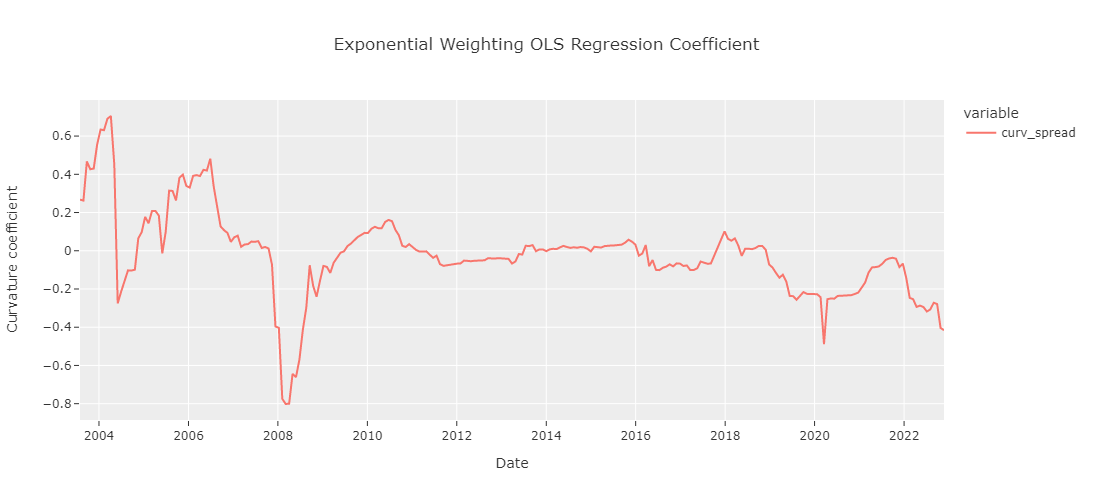

In [142]:
fig = px.line(
    exwt.params,
    # exwt.params.merge(df['pnl_pct'], how='left', left_index=True, right_index=True),
    labels = {
        'date': 'Date',
        'value': 'Curvature coefficient',
    },
    template=plotly_template,
    title='Exponential Weighting OLS Regression Coefficient',
    height=500,
)
fig

In [143]:
pred_df = df.merge(exwt.params, how='inner', left_index=True, right_index=True, suffixes=(None, '_coeff'))
pred_df['pnl_no_fees_pct_pred'] = pred_df['curv_spread'] * pred_df['curv_spread_coeff']
mse = (pred_df['pnl_no_fees_pct'] - pred_df['pnl_no_fees_pct_pred']).pow(2).mean()
ape = 100 * (pred_df['pnl_no_fees_pct'] - pred_df['pnl_no_fees_pct_pred']).abs() / pred_df['pnl_no_fees_pct'].abs()
print(f"Absolute Percent Error Statistics:")
ape.describe()

Absolute Percent Error Statistics:


count     253.000000
mean      143.101185
std       268.083764
min         0.000000
25%        60.939604
50%        95.238496
75%       116.859200
max      2666.000030
dtype: float64

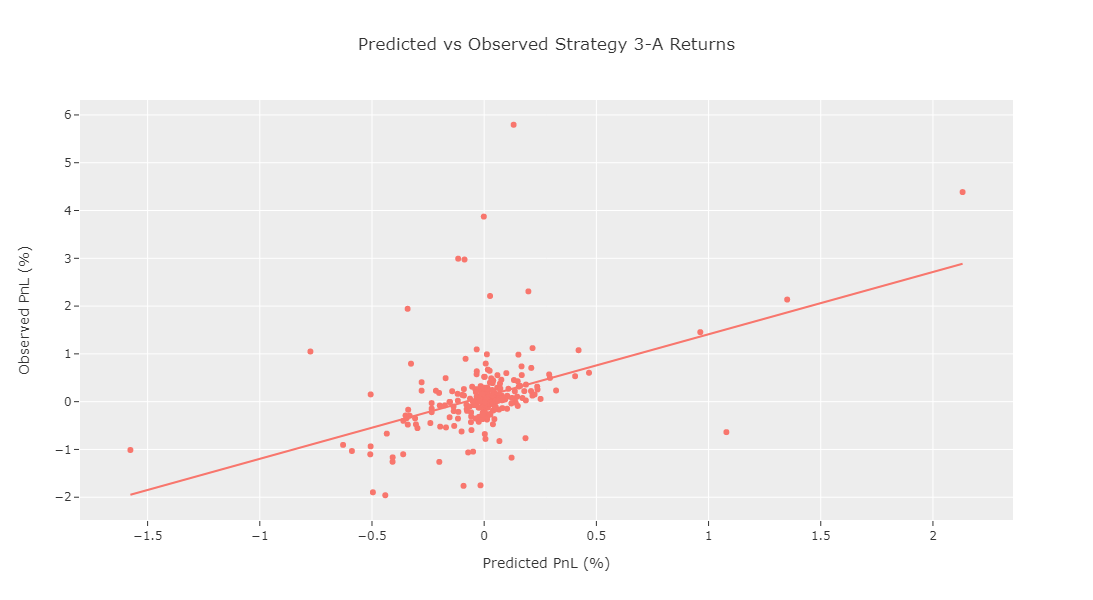

In [144]:
fig = px.scatter(
    pred_df.rename(columns={
        'pnl_no_fees_pct': 'Observed PnL (%)',
        'pnl_no_fees_pct_pred': 'Predicted PnL (%)',
    }),
    y='Observed PnL (%)',
    x='Predicted PnL (%)',
    template=plotly_template,
    trendline='ols',
    title='Predicted vs Observed Strategy 3-A Returns',
    height=600,
    width=800,
)
# fig.update_xaxes(
#     scaleanchor="y",
#     scaleratio=6.,
# )
fig

It looks like an exponentially weighted regression on last month's curvature can predict this month's barbell spread returns. Note the difference between the predicted vs observed variance: it's not surprising that there are significantly more tail events (interestingly, on the positive side) than the regression model expects.

# Analyze the PnL of Strategy p3A_135

I implemented the above strategy in `strat_returns.py` as the class `Stratp3A`. I ran a grid search on the following parameters:

- `ci_alpha`: Alpha of the confidence interval used for the PnL prediction. A value of 0.05 will place a trade if we're at least 95% sure that our PnL prediction will be positive, with fees. A value of 0.5 will place many more trades, since we only need to be >=50% sure that our PnL minus fees will be positive.
- `window_size`: Size of the window used for calculating the curvature Z score: $\frac{\text{curvature}\ -\ \mu_{\text{window_size}}}{\sigma_{\text{window_size}}}$. The curvature Z-score is used as the regressor in the exponentially weighted linear regression model.
- `half_life`: Half life decay of the exponential weights in the rolling linear regression model.

In [152]:
p3A_gs_results = parse_pnl_grid_search(
    'strat_p3A_135',
)
p3A_gs_results['sum_df']

,broker_borrow_rate,capital,ci_alpha,file_stub,half_life,leverage,start_date,tenors,window_size,sharpe
2,50,10000000,0.6,strat_p3A_135_half_life6_window_size13_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.356413
9,50,10000000,0.4,strat_p3A_135_half_life6_window_size13_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.350737
15,50,10000000,0.6,strat_p3A_135_half_life6_window_size102_ci_alp...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.322926
6,50,10000000,0.4,strat_p3A_135_half_life6_window_size102_ci_alp...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.296577
7,50,10000000,0.6,strat_p3A_135_half_life12_window_size13_ci_alp...,12,5.0,None,"[52.0, 156.0, 260.0]",13,0.290862
3,50,10000000,0.6,strat_p3A_135_half_life6_window_size52_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",52,0.264197
5,50,10000000,0.2,strat_p3A_135_half_life6_window_size13_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",13,0.252737
1,50,10000000,0.4,strat_p3A_135_half_life12_window_size13_ci_alp...,12,5.0,None,"[52.0, 156.0, 260.0]",13,0.250924
8,50,10000000,0.2,strat_p3A_135_half_life6_window_size102_ci_alp...,6,5.0,None,"[52.0, 156.0, 260.0]",102,0.250289
19,50,10000000,0.6,strat_p3A_135_half_life6_window_size26_ci_alph...,6,5.0,None,"[52.0, 156.0, 260.0]",26,0.216063


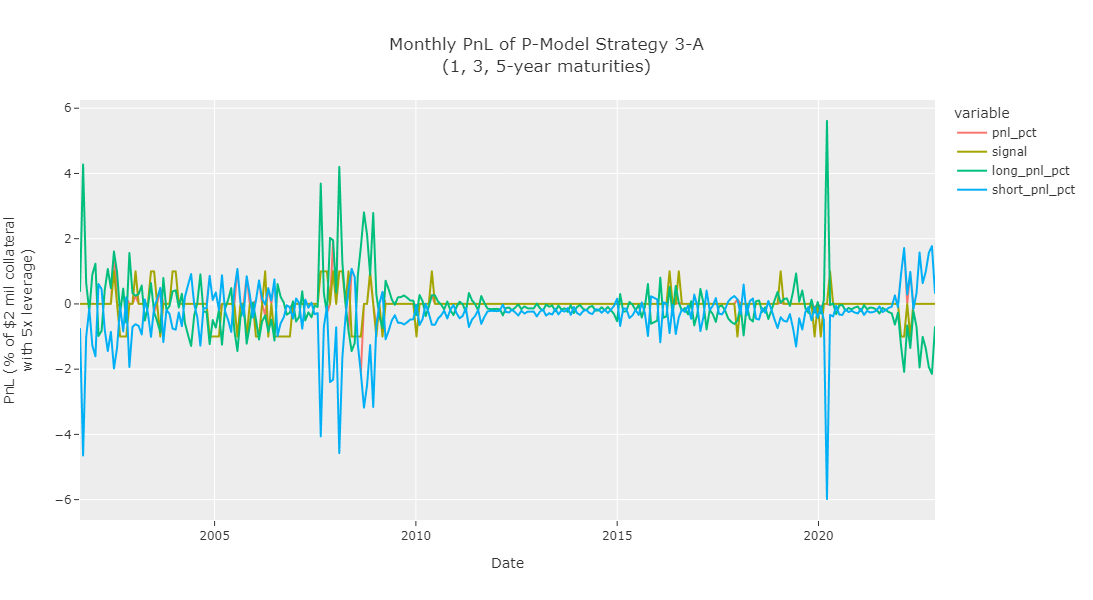

In [153]:
plot_pnl(
    'strat_p3A_135_half_life6_window_size13_ci_alpha0.6',
    title=f'Monthly PnL of P-Model Strategy 3-A<br>(1, 3, 5-year maturities)',
    height=600,
)

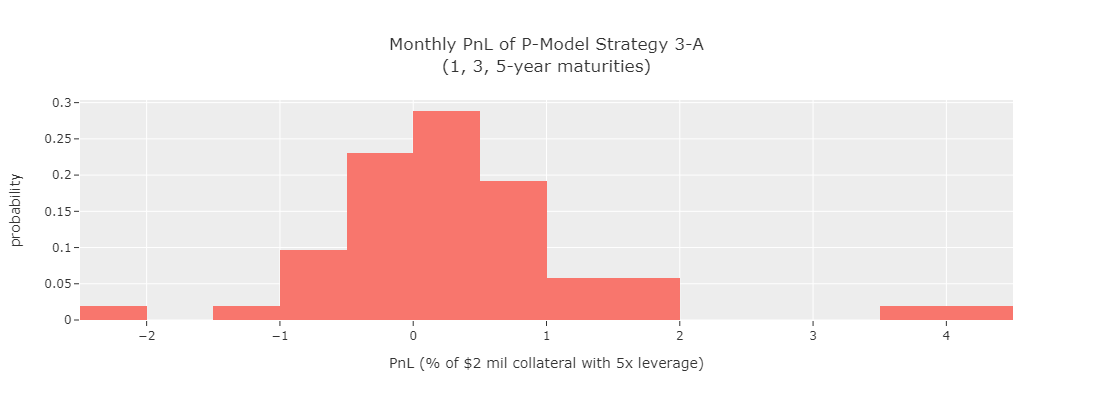

In [160]:
plot_pnl_dist(
    'strat_p3A_135_half_life6_window_size13_ci_alpha0.6',
    title=f'Monthly PnL of P-Model Strategy 3-A<br>(1, 3, 5-year maturities)',
    nbins=30,
    height=400,
)

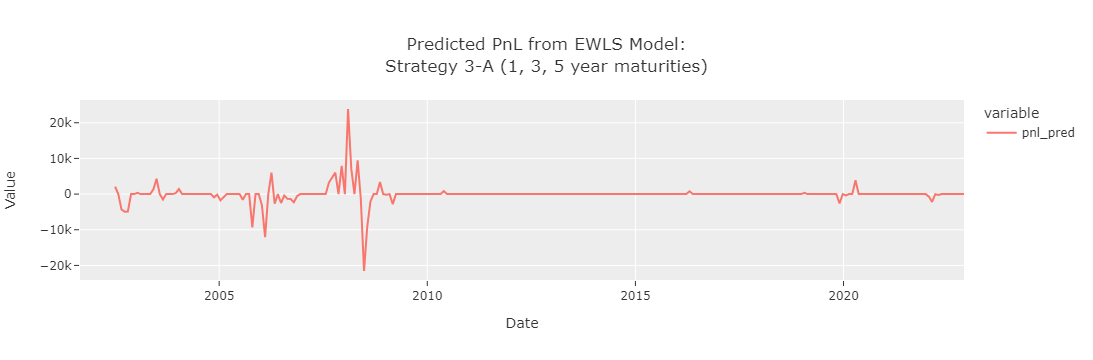

In [155]:
plot_signal(
    'strat_p3A_135_half_life6_window_size13_ci_alpha0.6',
    cols=['pnl_pred'],
    title=f'Predicted PnL from EWLS Model:<br>Strategy 3-A (1, 3, 5 year maturities)',
)

In [156]:
def get_pred_df(strat_name, **kw):
    pnl_fp = f"./data/final_proj/{strat_name}_pnl.csv"
    sig_fp = f"./data/final_proj/{strat_name}_signal.csv"
    pnl = pd.read_csv(pnl_fp, index_col=0, parse_dates=True)
    sig = pd.read_csv(sig_fp, index_col=0, parse_dates=True)
    df = pnl.merge(sig, how='outer', left_index=True, right_index=True, suffixes=('_pnl', '_sig'))
    return df
    fig = px.line(
        df[cols].rename({
        }),
        labels = {
            'date': 'Date',
            'value': 'Value',
        },
        template=plotly_template,
        **kw
    )
    return fig

p3A_pdf = get_pred_df(
    'strat_p3A_135_half_life6_window_size13_ci_alpha0.6',
    title=f'Trading Signal for Naive Strategy 2-A<br>(0.5 and 10 year maturities)',
)
p3A_pdf

,1,-1,0,pnl_no_fees,signal_pnl,pnl,pnl_pct,pnl_no_fees_pct,long_pnl_pct,short_pnl_pct,mean,std,curv_z,ci_lower,ci_upper,ci_mid,pnl_no_fees_pred,pnl_pred,signal_sig
date,,,,,,,,,,,,,,,,,,,
2001-08-29,7897.450595,-15341.237577,0,11619.344086,0,0.0,0.0,0.580967,0.394873,-0.767062,0.000016,0.000026,-0.363571,NaN,NaN,NaN,NaN,NaN,0
2001-09-26,85498.329052,-92942.116034,0,89220.222543,0,0.0,0.0,4.461011,4.274916,-4.647106,0.000016,0.000026,-0.640762,NaN,NaN,NaN,NaN,NaN,0
2001-10-24,12899.235916,-20343.022898,0,16621.129407,0,0.0,0.0,0.831056,0.644962,-1.017151,0.000016,0.000026,-0.351519,NaN,NaN,NaN,NaN,NaN,0
2001-11-21,-4582.359798,-2861.427184,0,-860.466307,0,0.0,0.0,-0.043023,-0.229118,-0.143071,0.000017,0.000026,0.265045,NaN,NaN,NaN,NaN,NaN,0
2001-12-19,18048.337836,-25492.124818,0,21770.231327,0,0.0,0.0,1.088512,0.902417,-1.274606,0.000025,0.000025,1.942371,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-03,-20211.426587,12767.639604,0,-16489.533095,0,0.0,0.0,-0.824477,-1.010571,0.638382,0.000056,0.000037,-1.485469,-1235.952018,-322.502563,-779.227290,1157.518122,0.0,0
2022-08-31,-27159.820604,19716.033622,0,-23437.927113,0,0.0,0.0,-1.171896,-1.357991,0.985802,0.000054,0.000040,-1.650173,1241.401801,2146.011758,1693.706780,-2794.908668,0.0,0
2022-09-28,-38739.361021,31295.574039,0,-35017.467530,0,0.0,0.0,-1.750873,-1.936968,1.564779,0.000053,0.000041,-0.879303,3086.751397,4111.791688,3599.271542,-3164.851997,0.0,0


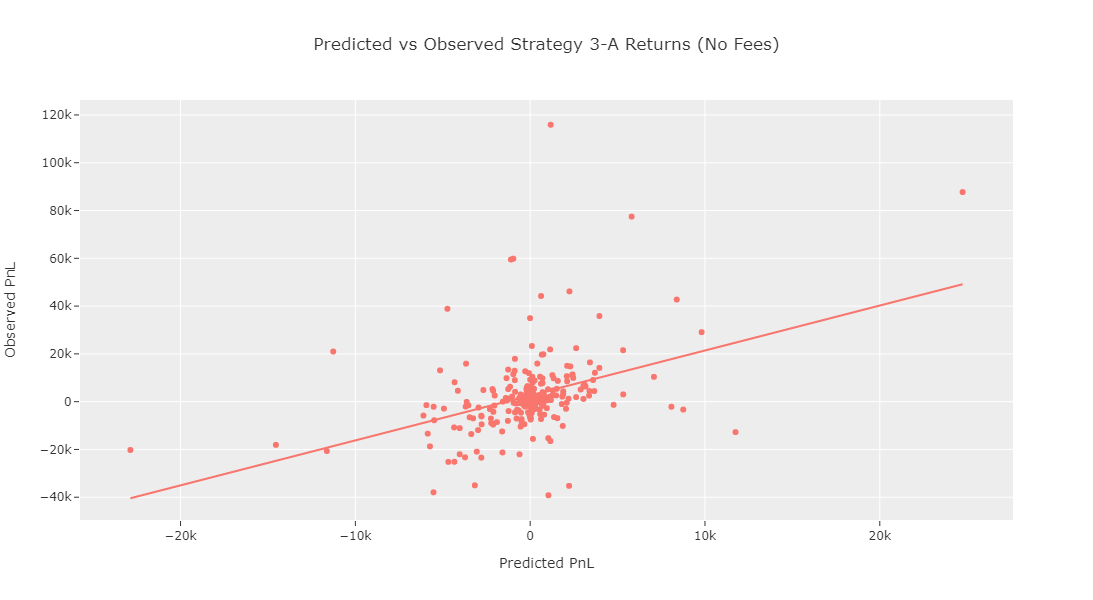

In [157]:
fig = px.scatter(
    p3A_pdf.rename(columns={
        'pnl_no_fees': 'Observed PnL',
        'pnl_no_fees_pred': 'Predicted PnL',
    }),
    y='Observed PnL',
    x='Predicted PnL',
    template=plotly_template,
    trendline='ols',
    title='Predicted vs Observed Strategy 3-A Returns (No Fees)',
    height=600,
    width=800,
)
# fig.update_xaxes(
#     scaleanchor="y",
#     scaleratio=6.,
# )
fig

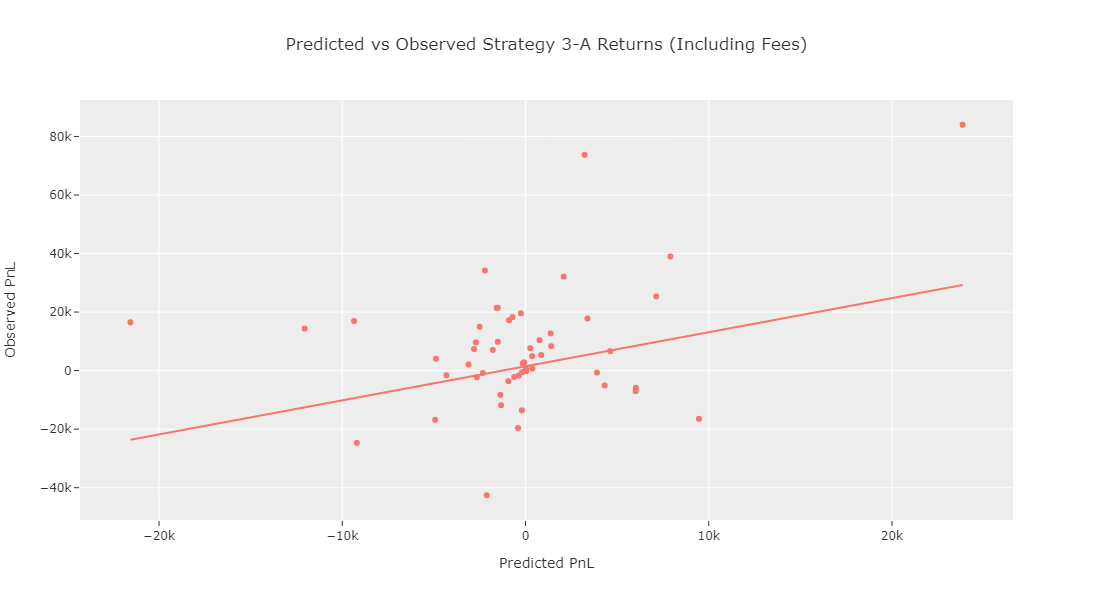

In [158]:
fig = px.scatter(
    p3A_pdf.rename(columns={
        'pnl': 'Observed PnL',
        'pnl_pred': 'Predicted PnL',
    }),
    y='Observed PnL',
    x='Predicted PnL',
    template=plotly_template,
    trendline='ols',
    title='Predicted vs Observed Strategy 3-A Returns (Including Fees)',
    height=600,
    width=800,
)
# fig.update_xaxes(
#     scaleanchor="y",
#     scaleratio=6.,
# )
fig

The p3A strategy performs much better than the n3A strategy, and it has a slightly positive Sharpe. We can see that the strategy can predict the observed PnL with and without fees. 